In [1]:
import os, tempfile
import logging

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum,
                                       schneider_taus,
                                       schneider_inact)

In [5]:
modelfile = 'models/courtemanche_ina.mmt'

# M gate -> already uses 'full' dataset

# H gate

In [9]:
observations, model, summary_statistics = setup(modelfile,
                                                schneider_inact,
                                                sakakibara_inact_kin_fast,
                                                sakakibara_rec_fast)

In [10]:
assert len(observations)==len(summary_statistics(model({})))

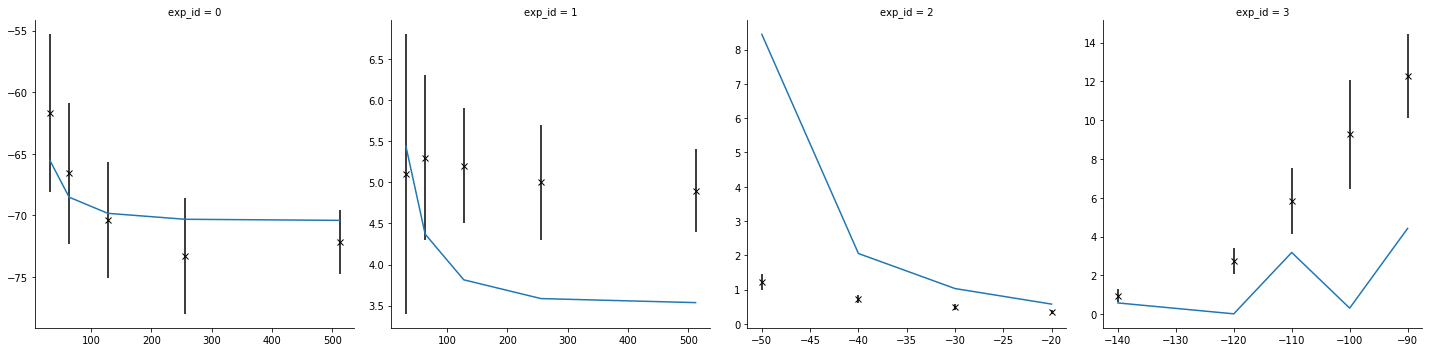

In [11]:
g = plot_sim_results(modelfile,
                     schneider_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast)

In [12]:
limits = {'ina.c1_h': (-100, 0),
          'log_ina.a1_h': (-2, 1),
          'ina.a2_h': (0, 50),
          'ina.a3_h': (0, 200),
          #'ina.b1_h': (0, 1),
          'ina.b2_h': (0, 100),
          'ina.b3_h': (0, 50),
          'log_ina.b4_h': (-1, 2),
          'log_ina.b5_h': (-3, 0),
          'log_ina.b6_h': (3, 6),
          'log_ina.b7_h': (-2, 1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [13]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_hgate_full.db"))

In [14]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [15]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=4),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9551156586926625, '1': 1.0724105641461474, '2': 1.3005830246027745, '3': 1.3005830246027745, '4': 1.6678690902136535, '5': 0.2599913581803636, '6': 0.4419853089066182, '7': 0.6314075841523116, '8': 0.6314075841523116, '9': 0.8839706178132364, '10': 0.5446357129453511, '11': 1.0722515598611597, '12': 1.4918282571981356, '13': 2.0848363627670667, '14': 1.6678690902136535, '15': 1.5501815160117751, '16': 0.6028242727804677, '17': 0.363824207621288, '18': 0.4764252051382466}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [17]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-30 09:51:48.778452, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 1283
DEBUG:Epsilon:new eps, t=1, eps=19.71779269136318
INFO:ABC:t:1 eps:19.71779269136318
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 3421
DEBUG:Epsilon:new eps, t=2, eps=13.328799921761997
INFO:ABC:t:2 eps:13.328799921761997
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 6217
DEBUG:Epsilon:new eps, t=3, eps=2.9147917050910492
INFO:ABC:t:3 eps:2.9147917050910492
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 10088
DEBUG:Epsilon:new eps, t=4, eps=1.7244293699749211
INFO:ABC:t:4 eps:1.7244293699749211
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 14320
DEBUG:Epsilon:new eps, t=5, eps=1.107572486288

### Database results analysis

In [17]:
history = History(db_path)

In [18]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-09-24 18:10:55.196815, end_time=2019-09-25 05:00:49.313710)>,
 <ABCSMC(id=2, start_time=2019-09-25 09:33:45.116794, end_time=2019-09-29 23:46:31.472322)>]

In [19]:
df, w = history.get_distribution(m=0)

In [20]:
df.describe()

name,ina.a2_h,ina.a3_h,ina.b2_h,ina.b3_h,ina.c1_h,log_ina.a1_h,log_ina.b4_h,log_ina.b5_h,log_ina.b6_h,log_ina.b7_h
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,15.627484,117.723710,20.591884,15.527716,-41.574421,-0.546374,1.177778,-1.237163,4.749208,0.373651
std,0.347905,22.427037,7.133076,2.471212,5.923283,0.620450,0.011225,0.003585,0.707234,0.365110
min,14.486852,64.500240,0.293657,11.263442,-58.123860,-1.998133,1.142843,-1.248021,3.000184,-0.556649
25%,15.424090,102.764118,15.711472,13.543166,-46.856111,-0.965005,1.170097,-1.239634,4.259559,0.121587
50%,15.677370,118.132372,22.901233,14.746011,-39.563764,-0.529836,1.177726,-1.237178,4.799034,0.415820
75%,15.873789,133.503225,26.197578,17.431789,-36.513025,-0.115891,1.185437,-1.234729,5.287091,0.660151
max,16.409736,175.434654,31.855868,22.895112,-32.907733,0.993192,1.211868,-1.226734,5.998103,0.998697


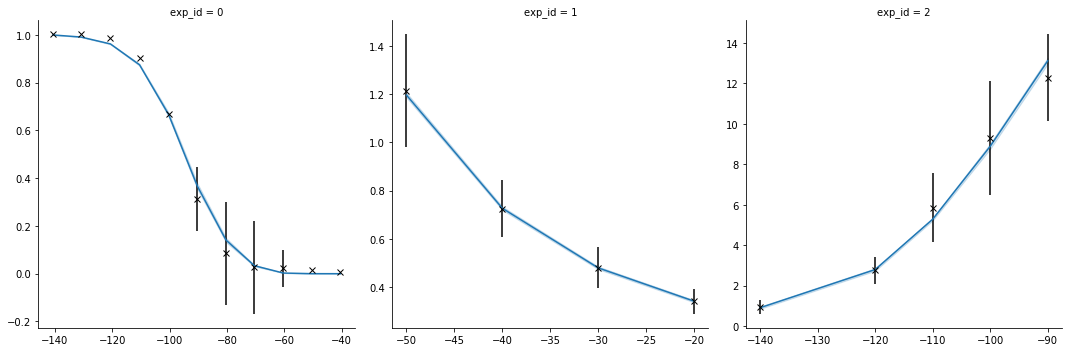

In [21]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_rec_fast,
                     df=df, w=w)

In [22]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

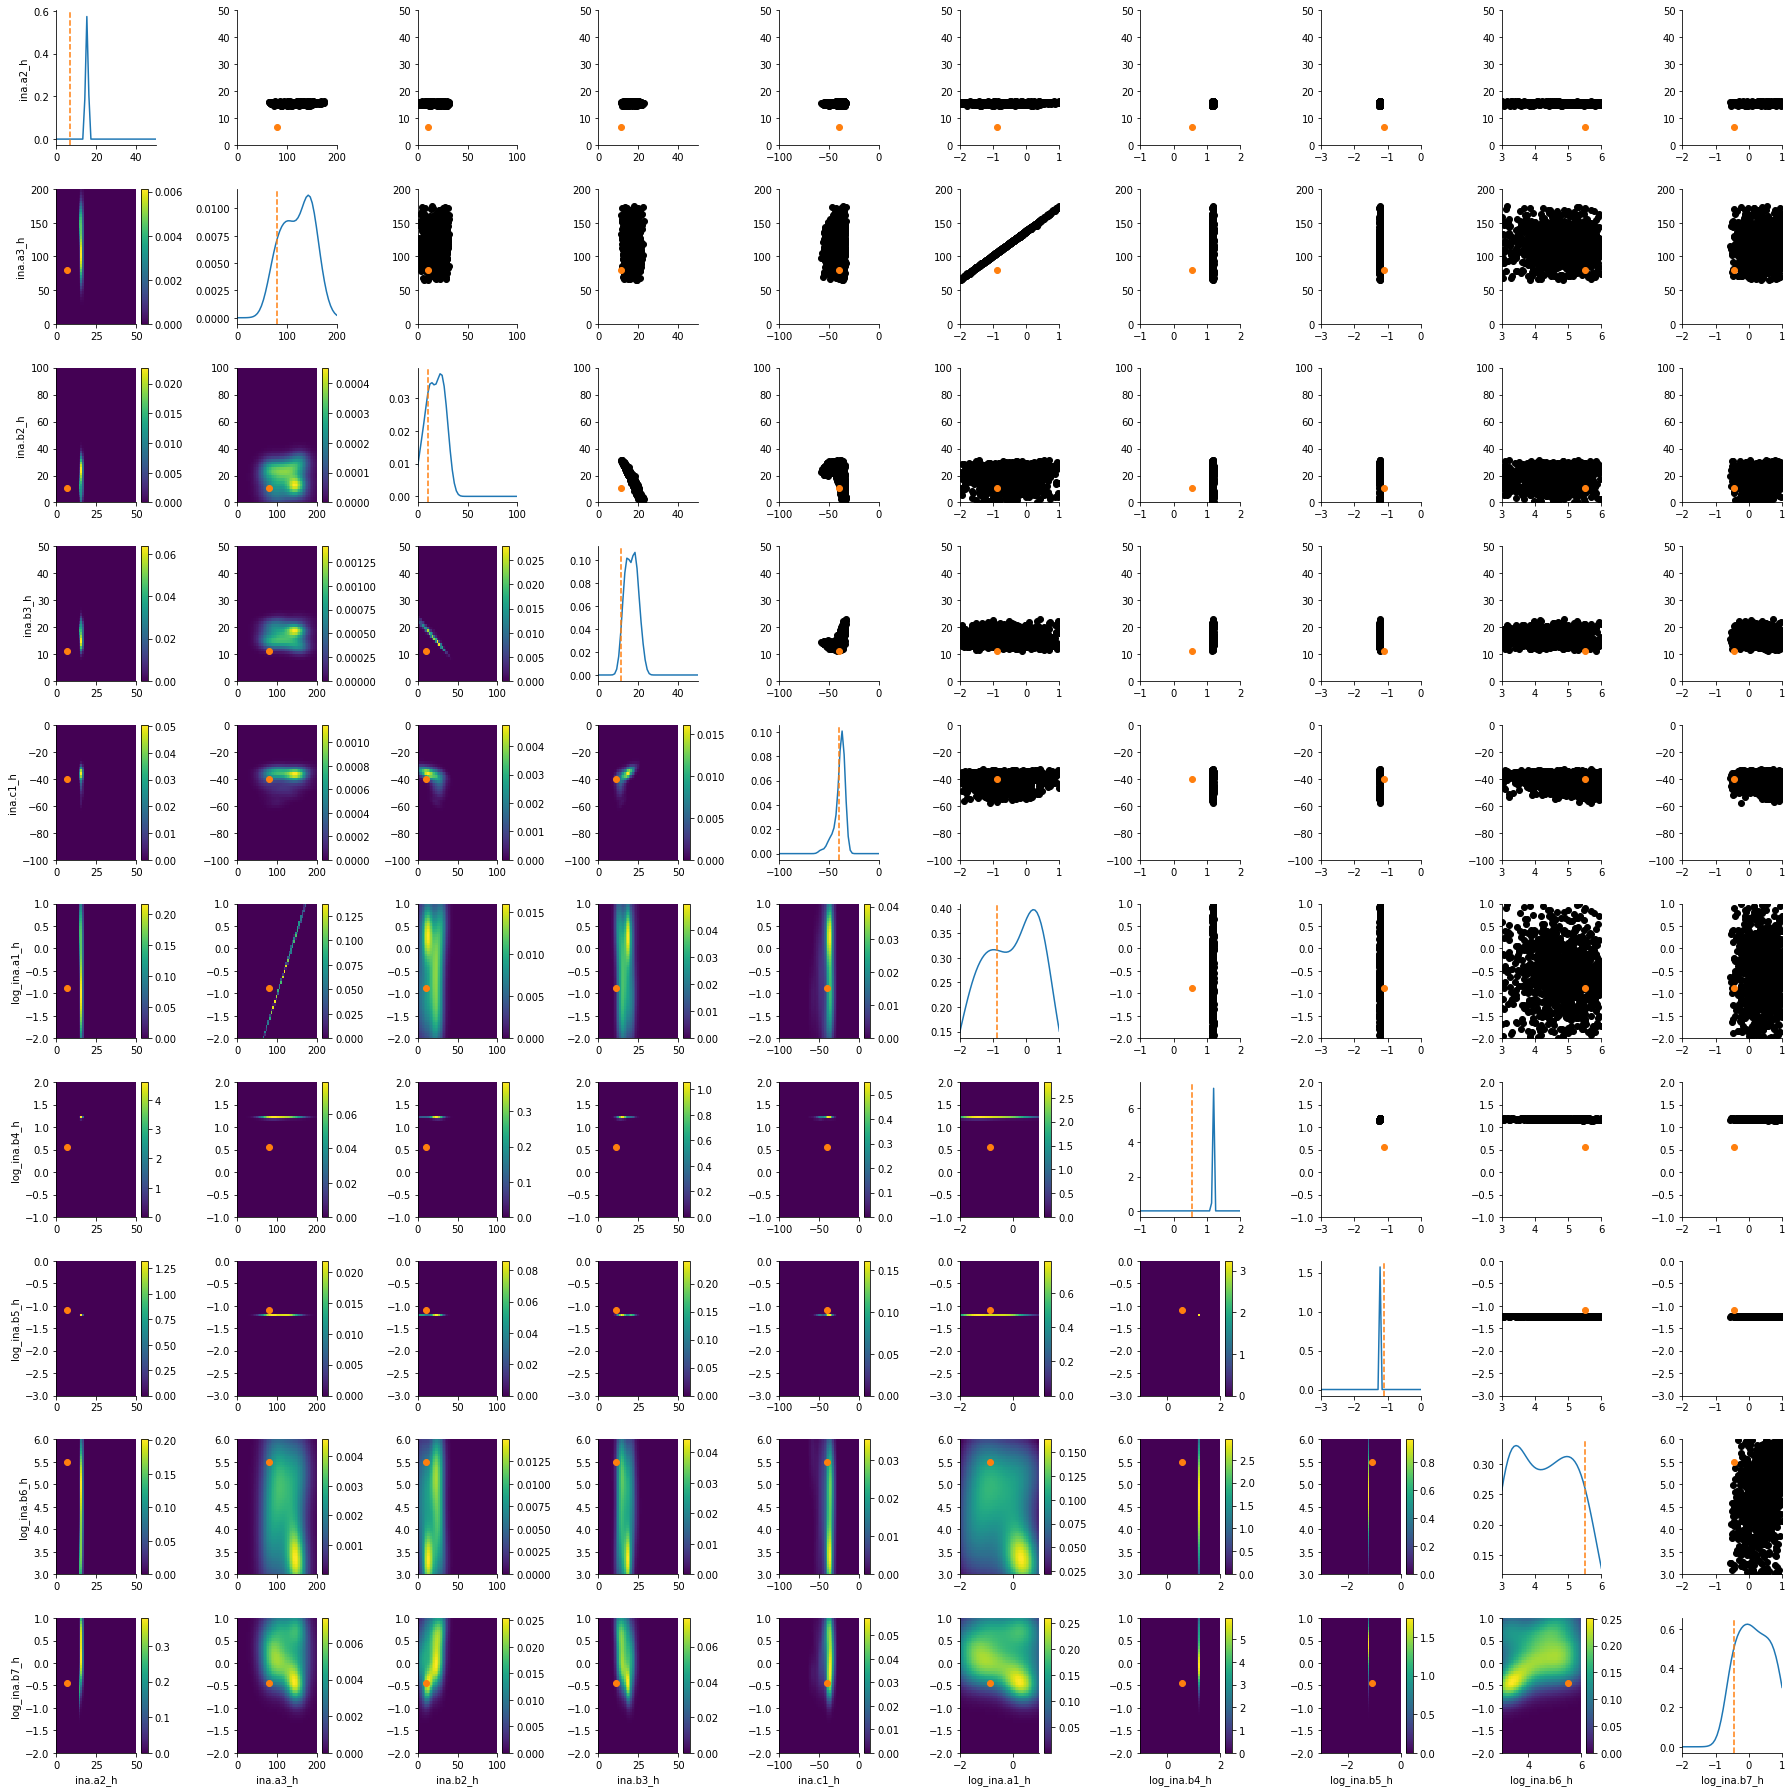

In [25]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# J gate

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                schneider_inact,
                                                sakakibara_inact_kin_slow,
                                                schneider_taus,
                                                sakakibara_rec_slow)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

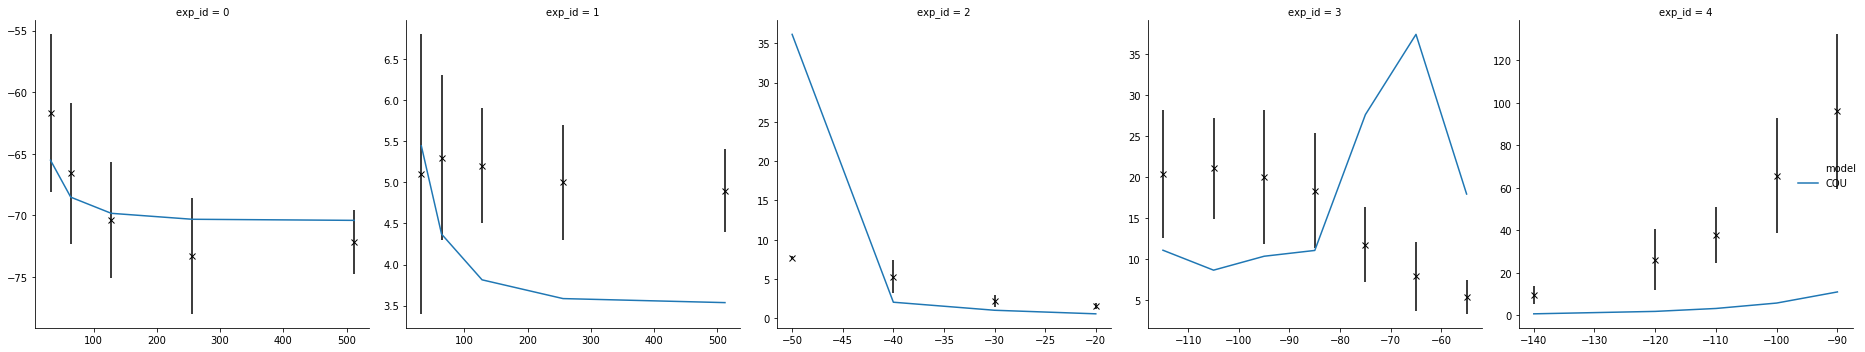

In [8]:
g = plot_sim_results(modelfile,
                     schneider_inact,
                     sakakibara_inact_kin_slow,
                     schneider_taus,
                     sakakibara_rec_slow)

In [9]:
limits = {'ina.c1_j': (-100, 0),
          'log_ina.a1_j': (4, 7),
          'log_ina.a2_j': (-2, 1),
          'log_ina.a3_j': (-5, -1),
          'log_ina.a4_j': (-3, -1),
          'ina.a5_j': (0, 100),
          'ina.a6_j': (0, 1),
          'ina.a7_j': (0, 100),
          #'ina.b1_j': (0, 1),
          'log_ina.b2_j': (-8, -6),
          'ina.b3_j': (0, 1),
          'ina.b4_j': (0, 100),
          'log_ina.b5_j': (-2, 1),
          'log_ina.b6_j': (-3, -1),
          'ina.b7_j': (0, 1),
          'ina.b8_j': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [10]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_jgate_full.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2414221203585345, '1': 1.3938774684727406, '2': 1.690447142615877, '3': 1.690447142615877, '4': 2.1678312606533754, '5': 0.337926637690085, '6': 0.5744752840731445, '7': 0.8206789772473493, '8': 0.8206789772473493, '9': 1.148950568146289, '10': 2.7097890758167194, '11': 0.49751634070542816, '12': 1.41792157101047, '13': 2.7097890758167194, '14': 0.20878357445941315, '15': 0.26378612295993753, '16': 0.19944585933526213, '17': 0.23252861960932358, '18': 0.3568303875968843, '19': 0.3818199063900119, '20': 0.7850103820100565, '21': 2.1678312606533754, '22': 0.7217702807554602, '23': 0.7880373777800581, '24': 0.38597691902102604, '25': 0.2864276669592352}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=3, start_time=2019-10-03 09:06:04.027541, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Database results analysis

In [19]:
history = History(db_path)

In [20]:
df, w = history.get_distribution(m=0)

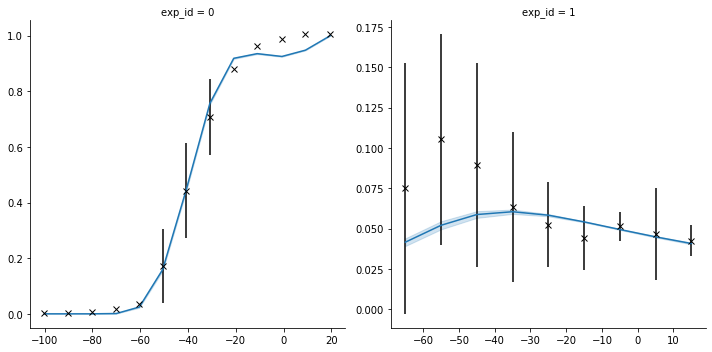

In [21]:
g = plot_sim_results(modelfile,
                     sakakibara_inact,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_slow,
                     df=df, w=w)

In [22]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

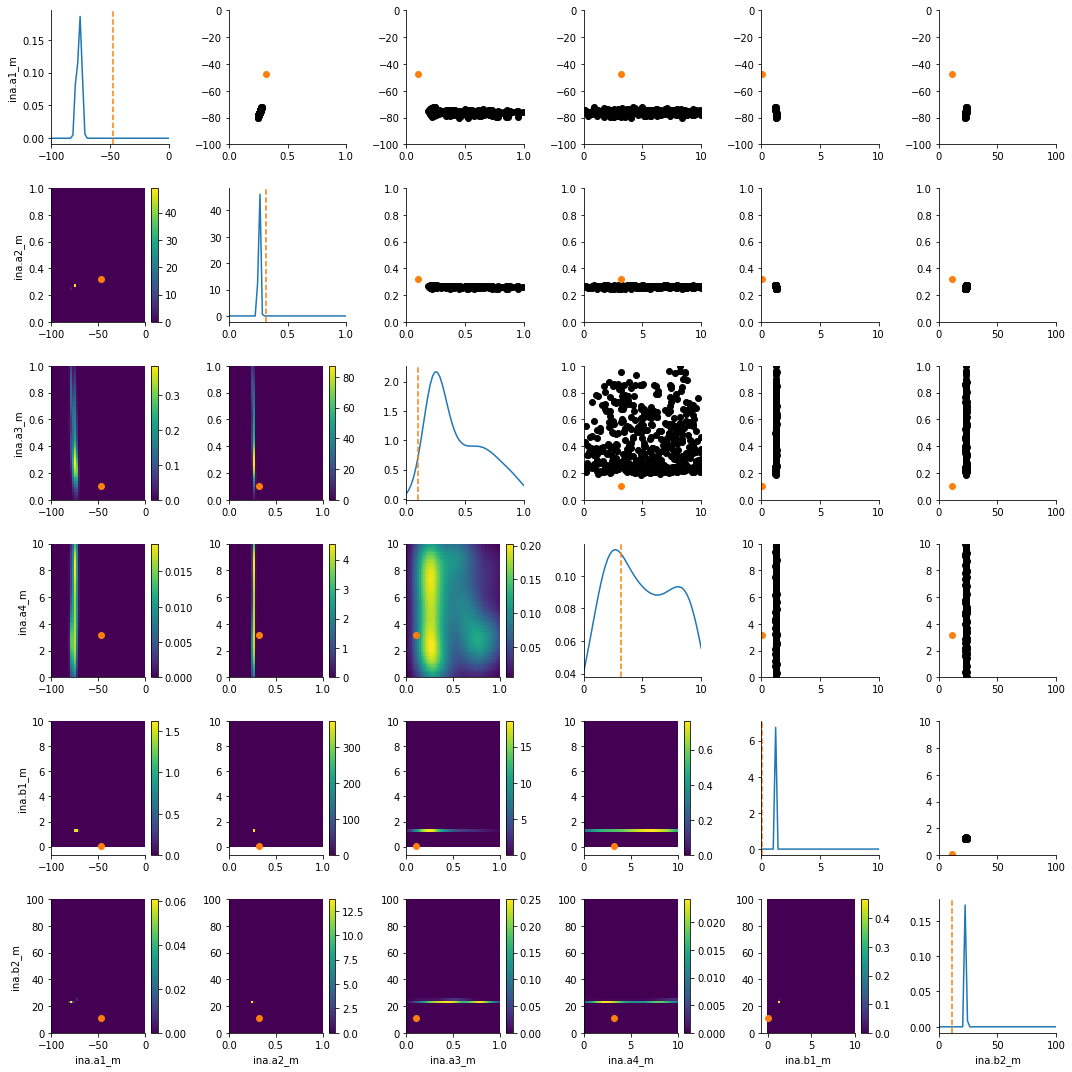

In [25]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)